In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('../prcp_monthly.csv')
data['month'] = pd.to_datetime(data['month'])
data.index = pd.date_range(start='2001-01-01', end='2020-12-31', freq='ME')
data.head()

,index,month,prcp
2001-01-31,0,2001-01-01,101.400000
2001-02-28,1,2001-02-01,98.200000
2001-03-31,2,2001-03-01,201.200000
2001-04-30,3,2001-04-01,141.200000
2001-05-31,4,2001-05-01,29.233333


Train test split:

In [120]:
train = data[data['month'].dt.year <= 2015]
test = data[data['month'].dt.year > 2015]

## 1. Simple ETS

Auto fit:

In [121]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

# Tự động chọn mô hình ETS tối ưu
model = ETSModel(train['prcp'], error="add", trend="add", seasonal="add", seasonal_periods=12)
fit = model.fit()
print(fit.summary())


                                 ETS Results                                  
Dep. Variable:                   prcp   No. Observations:                  180
Model:                       ETS(AAA)   Log Likelihood                -938.064
Date:                Sat, 22 Feb 2025   AIC                           1912.129
Time:                        22:10:24   BIC                           1969.602
Sample:                    01-31-2001   HQIC                          1935.432
                         - 12-31-2015   Scale                         1968.567
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.3447      0.066      5.184      0.000       0.214       0.475
smoothing_trend      3.447e-05        nan        nan        nan         nan         nan
smoothing_season

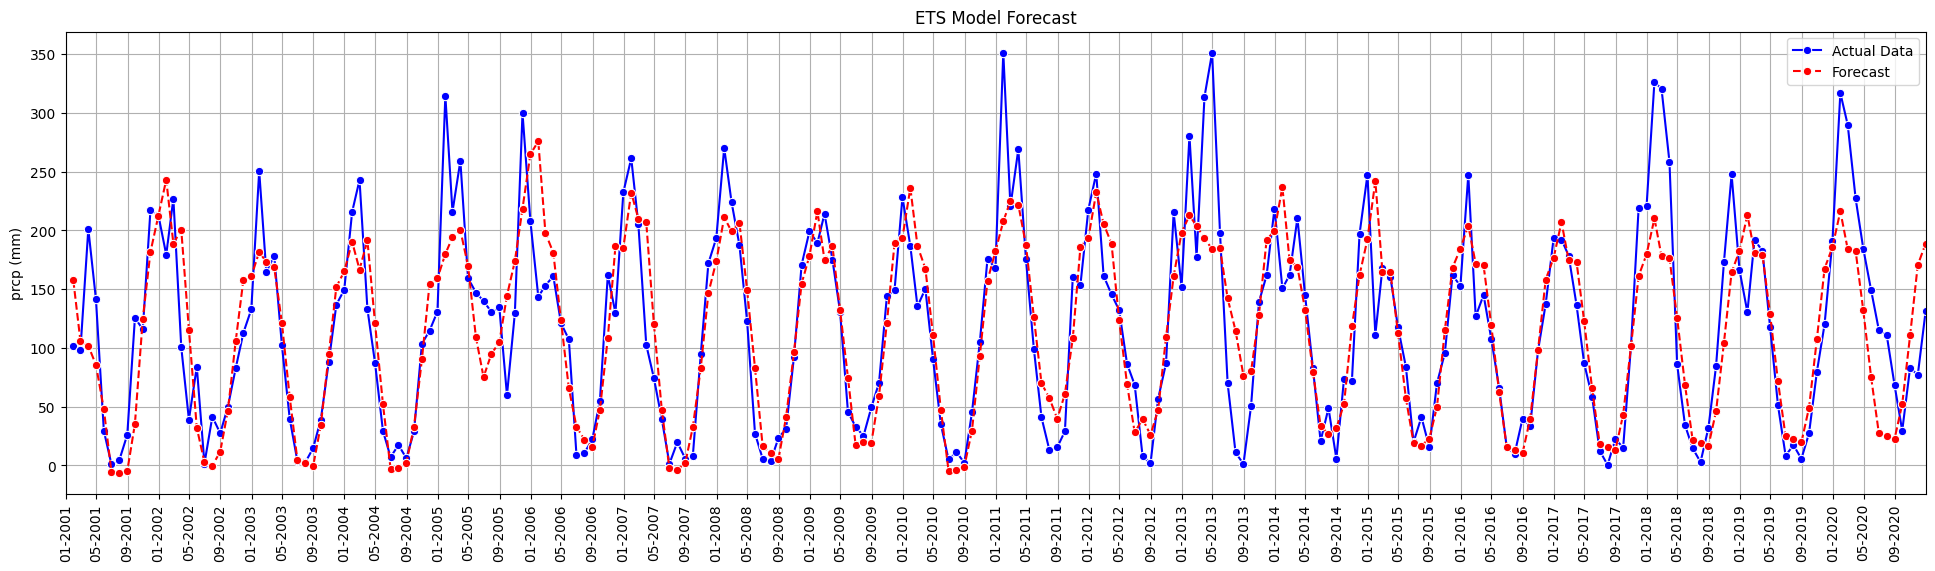

In [122]:
import seaborn as sns
import matplotlib.dates as mdates

forecast = fit.forecast(steps=len(test))
fitted_values = pd.concat([fit.fittedvalues, forecast])
fitted_values.index = pd.date_range(start='2001-01-01', end='2020-12-31', freq='ME')

plt.figure(figsize=(24, 6))
sns.lineplot(data["prcp"], label="Actual Data", color="blue", marker="o")
sns.lineplot(fitted_values, label="Forecast", color="red", linestyle="dashed", marker='o')
plt.xlim(pd.to_datetime("2001-01-01"), pd.to_datetime("2020-12-31"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.xticks(rotation=90)  
plt.grid(True)
plt.ylabel("prcp (mm)")
plt.title("ETS Model Forecast")
plt.legend()
# plt.savefig('../forecast/quarterly_ordinary_quadratic_model.png')
plt.show()

Evaluate:

In [123]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(test['prcp'], forecast)
rmse = mse ** 0.5
mae = mean_absolute_error(test['prcp'], forecast)
r2 = r2_score(test['prcp'], forecast)
aic = best_model.aic
bic = best_model.bic

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")
print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

MSE: 2441.13
RMSE: 49.41
MAE: 36.47
R²: 0.690
AIC: 1870.13
BIC: 1927.60


Grid search:

In [128]:
import itertools
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import r2_score

error_types = ["add", "mul"]
trend_types = [None, "add", "mul"]
seasonal_types = [None, "add", "mul"]

models = []
aics = []
r2s = []

for error, trend, seasonal in itertools.product(error_types, trend_types, seasonal_types):
    model = ETSModel(train['prcp'], error=error, trend=trend, seasonal=seasonal, seasonal_periods=12).fit()
    models.append(model)
    aics.append(model.aic)
    forecast = model.forecast(steps=len(test))
    r2s.append(r2_score(test['prcp'], forecast))


c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


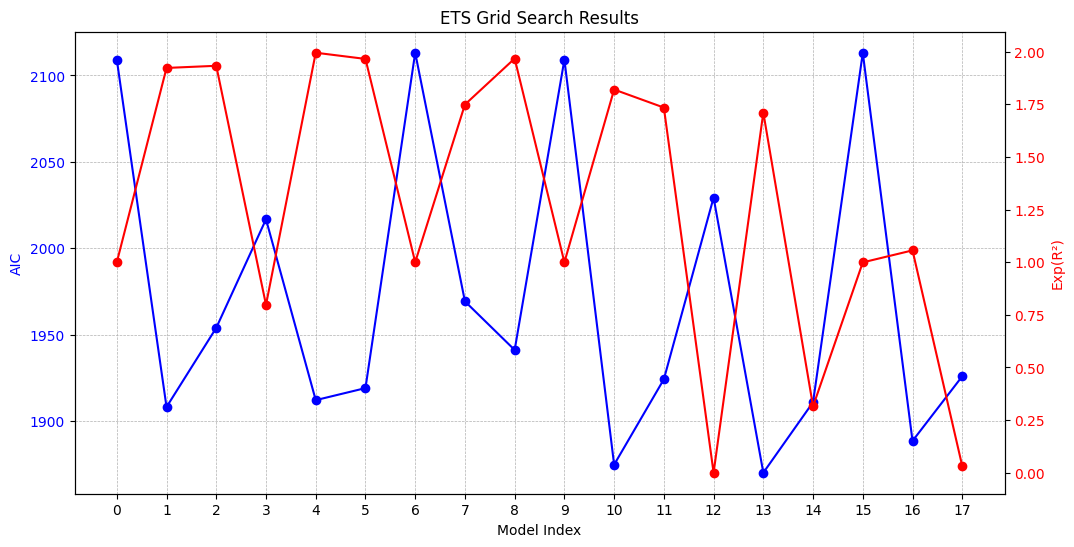

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Tạo figure
fig, ax1 = plt.subplots(figsize=(12, 6))

# Trục y thứ nhất (trái) - AIC
ax1.plot(aics, color="blue", marker="o", label="AIC")
ax1.set_xlabel("Model Index")
ax1.set_ylabel("AIC", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.set_xticks(range(0, 19))
ax1.grid(True, which="both", linestyle="--", linewidth=0.5)

# Tạo trục y thứ hai (phải) - Exp(R²)
ax2 = ax1.twinx()
ax2.plot(np.exp(r2s), color="red", marker="o", label="Exp(R²)")
ax2.set_ylabel("Exp(R²)", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Tiêu đề
plt.title("ETS Grid Search Results")

# plt.savefig('ets_grid_search.png')
plt.show()


- Due to the graph, we will choose 4th model

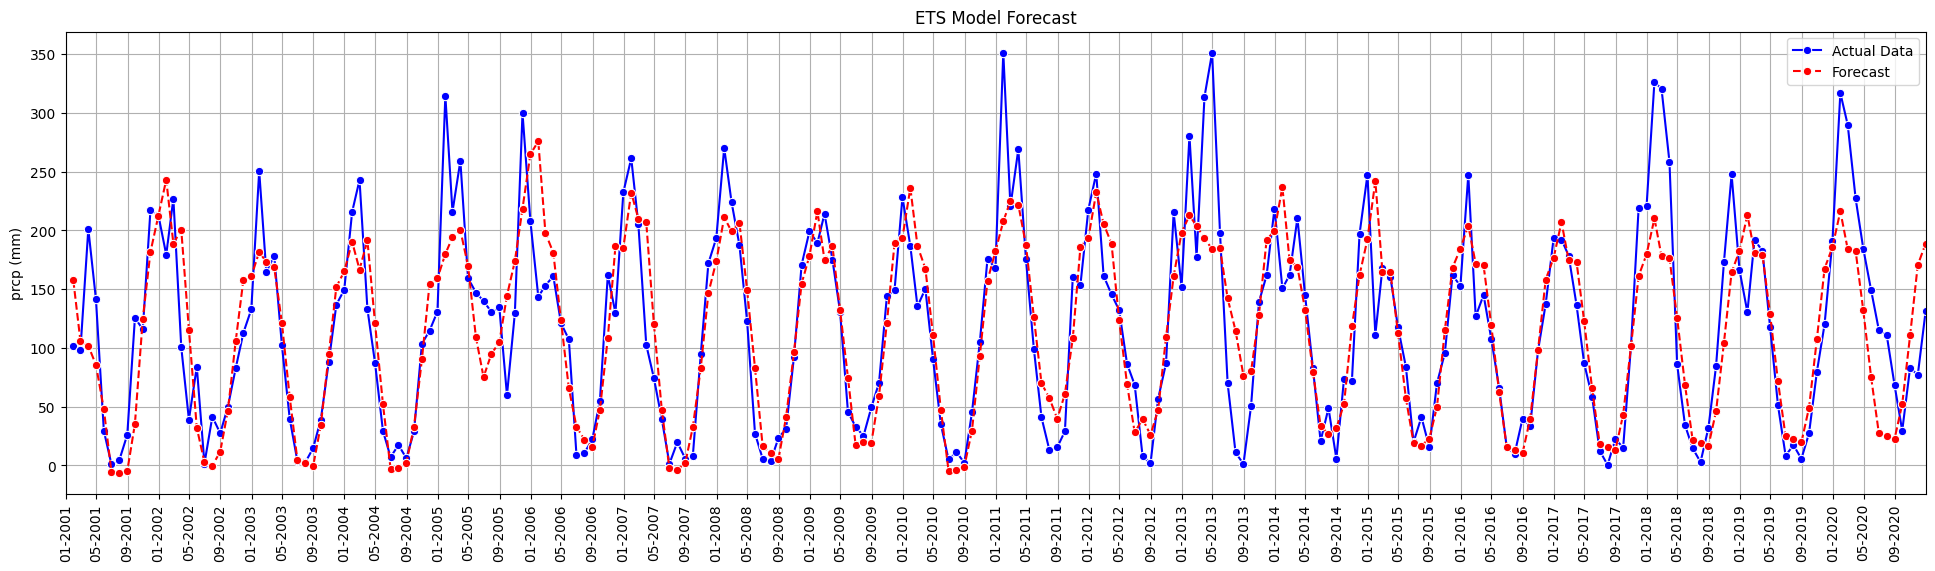

In [ ]:
import seaborn as sns
import matplotlib.dates as mdates

best_model = models[4]
forecast = best_model.forecast(steps=len(test))
fitted_values = pd.concat([best_model.fittedvalues, forecast])
fitted_values.index = pd.date_range(start='2001-01-01', end='2020-12-31', freq='ME')

plt.figure(figsize=(24, 6))
sns.lineplot(data["prcp"], label="Actual Data", color="blue", marker="o")
sns.lineplot(fitted_values, label="Forecast", color="red", linestyle="dashed", marker='o')
plt.xlim(pd.to_datetime("2001-01-01"), pd.to_datetime("2020-12-31"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.xticks(rotation=90)  
plt.grid(True)
plt.ylabel("prcp (mm)")
plt.title("ETS Model Forecast")
plt.legend()
# plt.savefig('../forecast/simple_ets_model.png')
plt.show()

Evaluate best model:

In [143]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(test['prcp'], forecast)
rmse = mse ** 0.5
mae = mean_absolute_error(test['prcp'], forecast)
r2 = r2_score(test['prcp'], forecast)
aic = best_model.aic
bic = best_model.bic

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")
print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

MSE: 2441.13
RMSE: 49.41
MAE: 36.47
R²: 0.690
AIC: 1912.13
BIC: 1969.60


- It turns out that the first model we tried is the best model.

## 2. Holt's method

In [ ]:
from statsmodels.exponential_smoothing.ets import Holt